# 1 Feedforward Neural Network

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(42)

train_x, train_y = np.load('train_x.npy'), np.load('train_y.npy')
test_x, test_y = np.load('test_x.npy'), np.load('test_y.npy')

print('shape of data:')
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

checkpoint = np.load('weights.npy', allow_pickle = True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

weights = init_weights
biases = init_biases

print('shape of weights:')
for w in init_weights:
    print(w.shape)    
print()
print('shape of biases:')
for b in init_biases:
    print(b.shape)

shape of data:
(4500, 784)
(4500,)
(500, 784)
(500,)
shape of weights:
(784, 2048)
(2048, 512)
(512, 5)

shape of biases:
(2048,)
(512,)
(5,)


## Model

In [9]:
''' NORMALIZE '''
train_x = train_x / 255.0
test_x = test_x / 255.0

def softmax(x):
    return np.exp(x - np.max(x, axis = 1, keepdims = True)) / np.sum(np.exp(x - np.max(x, axis = 1, keepdims = True)), axis = 1, keepdims=True)

def ReLU(x):
    return x * (x > 0)

def derivative_ReLU(x):
    return (x > 0).astype(int)

class Model():
    def __init__(self, weight, bias, lr, initial, dropout_rate) -> None:
        if initial == False:
            self.w1 = weight[0]
            self.w2 = weight[1]
            self.w3 = weight[2]
            self.b1 = bias[0]
            self.b2 = bias[1]
            self.b3 = bias[2]
        else:
            self.w1 = np.zeros((784, 2048))
            self.w2 = np.zeros((2048, 512))
            self.w3 = np.zeros((512, 5))
            self.b1 = np.zeros(2048, )
            self.b2 = np.zeros(512, )
            self.b3 = np.zeros(5, )

        self.lr =lr
        self.dropout_rate = dropout_rate
        self.optimizer = SGD(lr, self.w1, self.w2, self.w3, self.b1, self.b2, self.b3)

    def cross_entropy_loss(self, y_pred, y_hat):
        self.y_pred = y_pred
        self.y_hat = y_hat
        self.true = np.eye(5)[y_hat]
        return - np.sum(self.true * np.log(y_pred + 1e-323)) / len(y_pred)

    def cross_entropy_grad(self):
        return (self.y - self.true)

    def forward(self, input, true, drop):
        self.input = input      
        self.true = true  
        if  drop == True:
            drop1 = np.random.choice([0, 1], size = (self.input.shape[0], len(self.b1)), p = [self.dropout_rate, 1.0 - self.dropout_rate])
            drop2 = np.random.choice([0, 1], size = (self.input.shape[0], len(self.b2)), p = [self.dropout_rate, 1.0 - self.dropout_rate])
            # print(drop1)
            # print(drop2)
            self.A1 = ReLU(self.input @ self.w1 + self.b1)            # (batch_size, 2048)
            self.A2 = ReLU((self.A1 * drop1) @ self.w2 + self.b2)     # (batch_size, 512)
            self.y = softmax((self.A2 * drop2) @ self.w3 + self.b3)   # (batch_size, 5)             
        else:                
            self.A1 = ReLU(self.input @ self.w1 + self.b1)       # (batch_size, 2048)
            self.A2 = ReLU(self.A1 @ self.w2 + self.b2)          # (batch_size, 512)
            self.y = softmax(self.A2 @ self.w3 + self.b3)        # (batch_size, 5)   
        # print("a2: ", self.A2)
        return self.y
    
    def backward(self):
        activation1_der = derivative_ReLU(self.A1)           # (batch_size, 2048)
        activation2_der = derivative_ReLU(self.A2)           # (batch_size, 512)
        # print("relu:",self.A2)

        z3_der = self.cross_entropy_grad()                   # (batch_size, 5)
        z2_der = activation2_der * (z3_der @ self.w3.T)      # (batch_size, 512)
        z1_der = activation1_der * (z2_der @ self.w2.T)      # (batch_size, 2048)
        # print("z3_der ", z3_der)

        self.w3_grad = (self.A2.T @ z3_der) / self.input.shape[0]      # (512, 5)
        self.w2_grad = (self.A1.T @ z2_der) / self.input.shape[0]      # (2048, 512)
        self.w1_grad = (self.input.T @ z1_der) / self.input.shape[0]   # (784, 2048)
        #print("w3_grad: ", self.w3_grad)

        self.b3_grad = z3_der.sum(axis = 0) / self.input.shape[0]    # (5,)
        self.b2_grad = z2_der.sum(axis = 0) / self.input.shape[0]    # (512,)
        self.b1_grad = z1_der.sum(axis = 0) / self.input.shape[0]    # (2048,)

    def update(self):
        self.optimizer.update(self.w1_grad, self.w2_grad, self.w3_grad, self.b1_grad, self.b2_grad, self.b3_grad)

class optimizer():
    def __init__(self, lr, *weights) -> None:
        self.lr = lr
        self.weights = list(weights)

    def update(self, *gradients):
        for i, grad in enumerate(gradients):
            self.weights[i] -= (grad * self.lr)

class SGD(optimizer):
    def __init__(self, lr, *weights) -> None:
        super().__init__(lr, *weights)

    def update(self, *gradients):
        return super().update(*gradients)

def plot_lr_curve(train, test):
    plt.figure(figsize = (15, 10))
    plt.title("training and testing loss", fontsize = 25)
    x_label = range(0, 675, 25)
    plt.plot(x_label, train, color = "red", label = "train", marker = "o", markersize = 10)
    plt.plot(x_label, test, color = "blue", label = "test", marker = "o")
    plt.xticks(range(0, 675, 25))
    plt.xlabel("Iteration", fontsize = 20)
    plt.ylabel("Loss", fontsize = 20)
    plt.legend(loc = "best", fontsize = "20")
    plt.show()

def plot_acc_curve(train, test):
    plt.figure(figsize = (15, 10))
    plt.title("training and testing accuracy", fontsize = 25)
    x_label = range(0, 675, 25)
    plt.plot(x_label, train, color = "red", label = "train", marker = "o", markersize = 10)
    plt.plot(x_label, test, color = "blue", label = "test", marker = "o")
    plt.xticks(range(0, 675, 25))
    plt.xlabel("Iteration", fontsize = 20)
    plt.ylabel("Accuracy", fontsize = 20)
    plt.legend(loc = "best", fontsize = "20")
    plt.show()

def accuracy(y_pred, y_hat):
    pred = y_pred.argmax(axis = 1)
    hat = y_hat.argmax(axis = 1)
    acc = 0
    for pred, hat in zip(pred, hat):
        if pred == hat:
            acc += 1
    return (acc / len(y_pred))

def train(model, epoch, batch_size, drop, shuffle):
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []

    if (train_x.shape[0]) % batch_size == 0:
        num = (train_x.shape[0]) // batch_size
    else:
        num = (train_x.shape[0]) // batch_size + 1

    count = 1
    total_loss = 0
    total_acc = 0
    for i in range(epoch):
        for j in range(num):
            if j == (num - 1):
                input = train_x[batch_size * j:, :]
                y_hat = train_y[batch_size * j:]
            else:
                input = train_x[batch_size * j:batch_size * (j + 1), :]
                y_hat = train_y[batch_size * j:batch_size * (j + 1)]

            if shuffle == True:
                y_hat = y_hat.reshape(len(y_hat), 1)
                stack = np.hstack((input, y_hat))
                np.random.default_rng(seed=42).shuffle(stack)
                input = stack[:len(stack), :stack.shape[1] - 1]
                y_hat = stack[:len(stack), stack.shape[1] - 1:].reshape(len(stack), ).astype(int)
                # print(y_hat)

            true = np.eye(5)[y_hat]
            test_true = np.eye(5)[test_y]
                       
            y_pred = model.forward(input, true, drop)    
            total_loss += model.cross_entropy_loss(y_pred, y_hat)
            total_acc += accuracy(y_pred, true)

            if count % 25 == 0:
                loss = model.cross_entropy_loss(y_pred, y_hat)
                train_losses = np.append(train_losses, total_loss / 25.0)      
                train_acc = np.append(train_acc, total_acc / 25.0)
                total_loss = 0
                total_acc = 0
                # print("epoch: ", i + 1)
                # print("iteration: " , count)
                # print("train loss = " , loss)
                # print("train acc = " , accuracy(y_pred, true))
            
            model.backward()
            model.update()
            test_pred = model.forward(test_x, test_true, drop = False)

            if count % 25 == 0:
                test_loss = model.cross_entropy_loss(test_pred, test_y)
                test_losses = np.append(test_losses, test_loss)
                test_acc = np.append(test_acc, accuracy(test_pred, test_true))
                # print("test loss = " , test_loss)
                # print("test acc = " , accuracy(test_pred, test_true))
                # print("--------------------------------------")
            count += 1
    
    print("Final Train Loss:     ", train_losses[-1])
    print("Final Train Accuracy: ", train_acc[-1] * 100, "%")
    print()
    print("Final Test Loss:      ", test_losses[-1])
    print("Final Test Accuracy:  ", test_acc[-1] * 100, "%")
    plot_lr_curve(train_losses, test_losses)
    print()
    plot_acc_curve(train_acc, test_acc)
    print()

# 1.(a) Plot the learning curves of J(w) and the accuracy of classification for every 25 iterations.

FNN model architecture:
--------------------------------------
Final Train Loss:      0.44484363815437816
Final Train Accuracy:  97.77999999999999 %

Final Test Loss:       22.62792812781551
Final Test Accuracy:   77.8 %


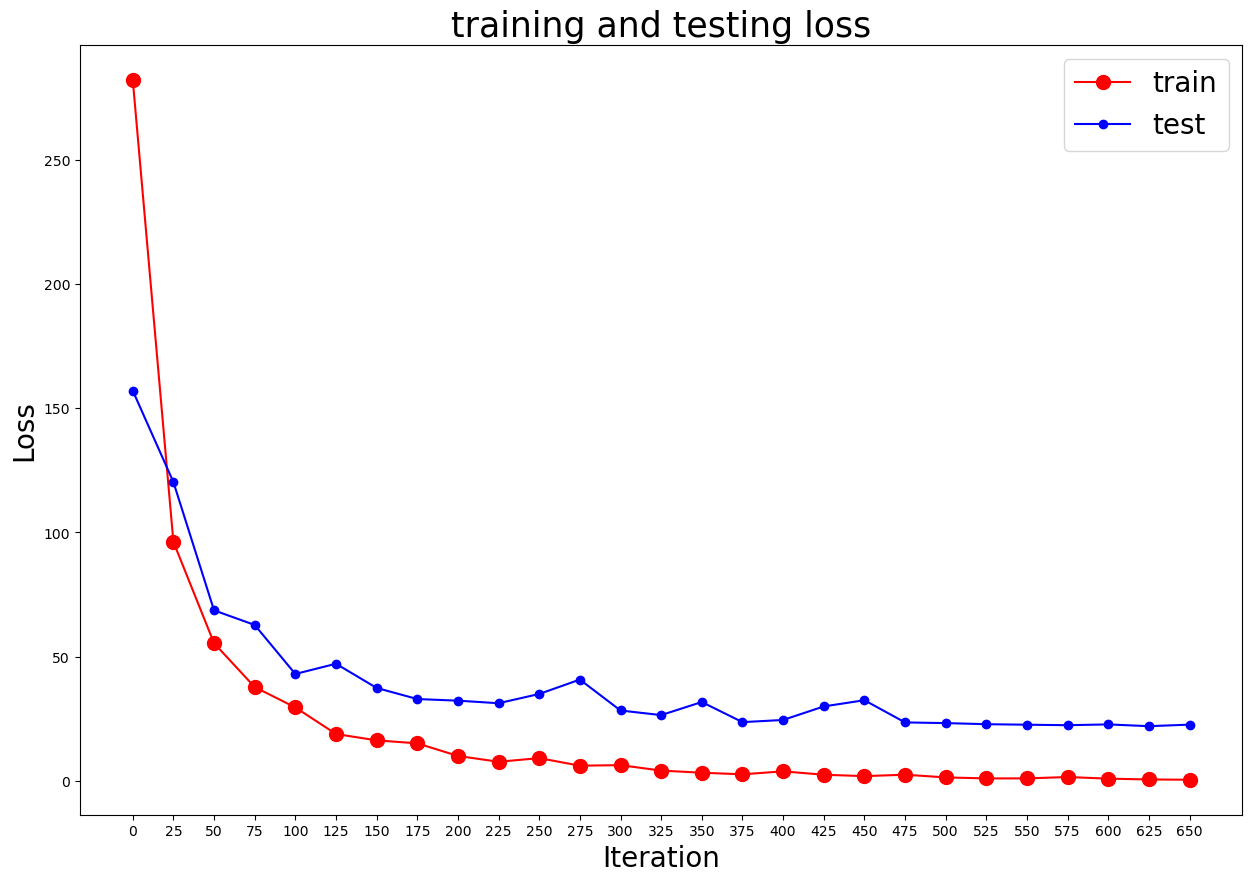

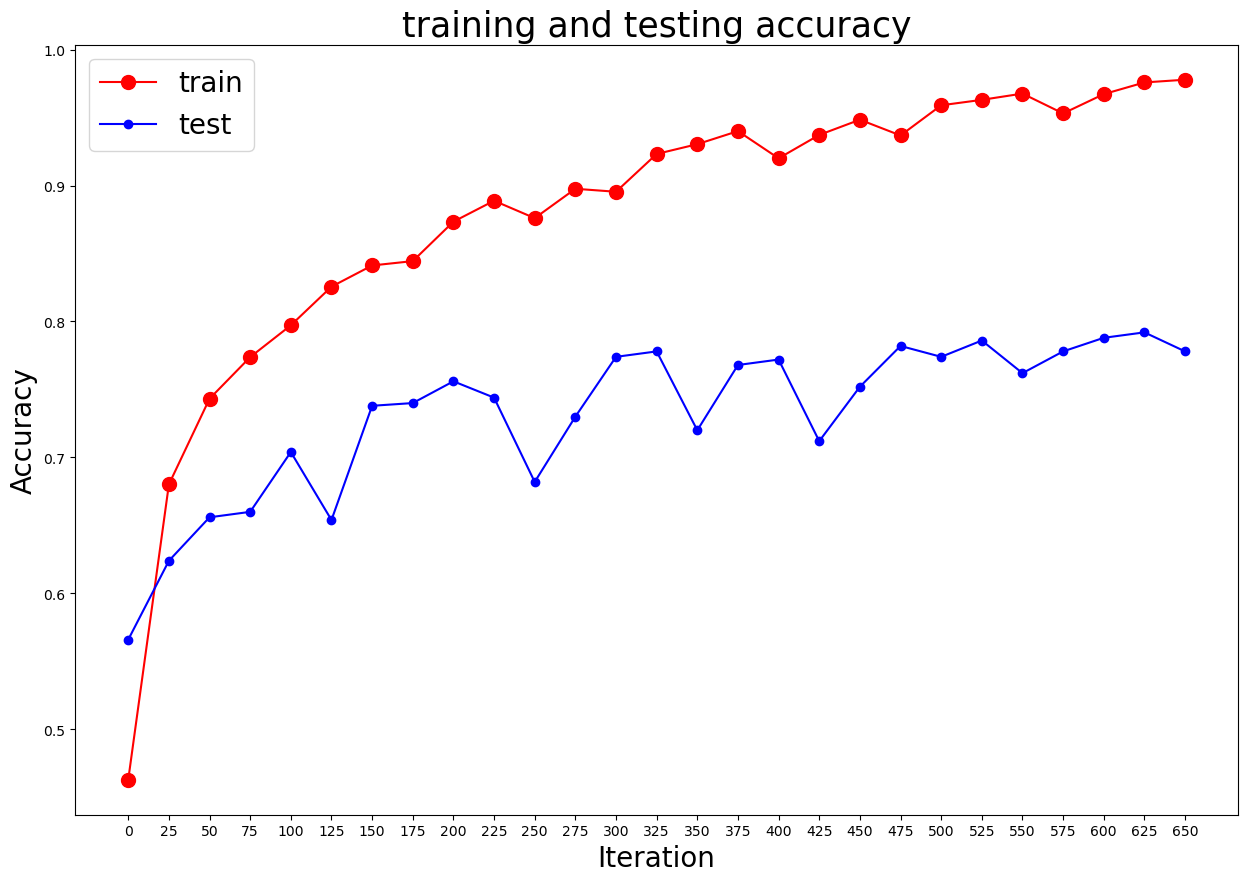

In [10]:
''' START TRAINING '''
FNN_model = Model(weights, biases, lr = 0.01, initial = False, dropout_rate = 0.2)
print("FNN model architecture:")
print("--------------------------------------")
train(FNN_model, epoch = 30, batch_size = 200, drop = False, shuffle = False)

# 1.(b) Repeat 1(a) by considering zero initialization for the model weights.

FNN model architecture:
--------------------------------------
Final Train Loss:      1.6094379124341005
Final Train Accuracy:  20.000000000000007 %

Final Test Loss:       1.6094379124341003
Final Test Accuracy:   20.0 %


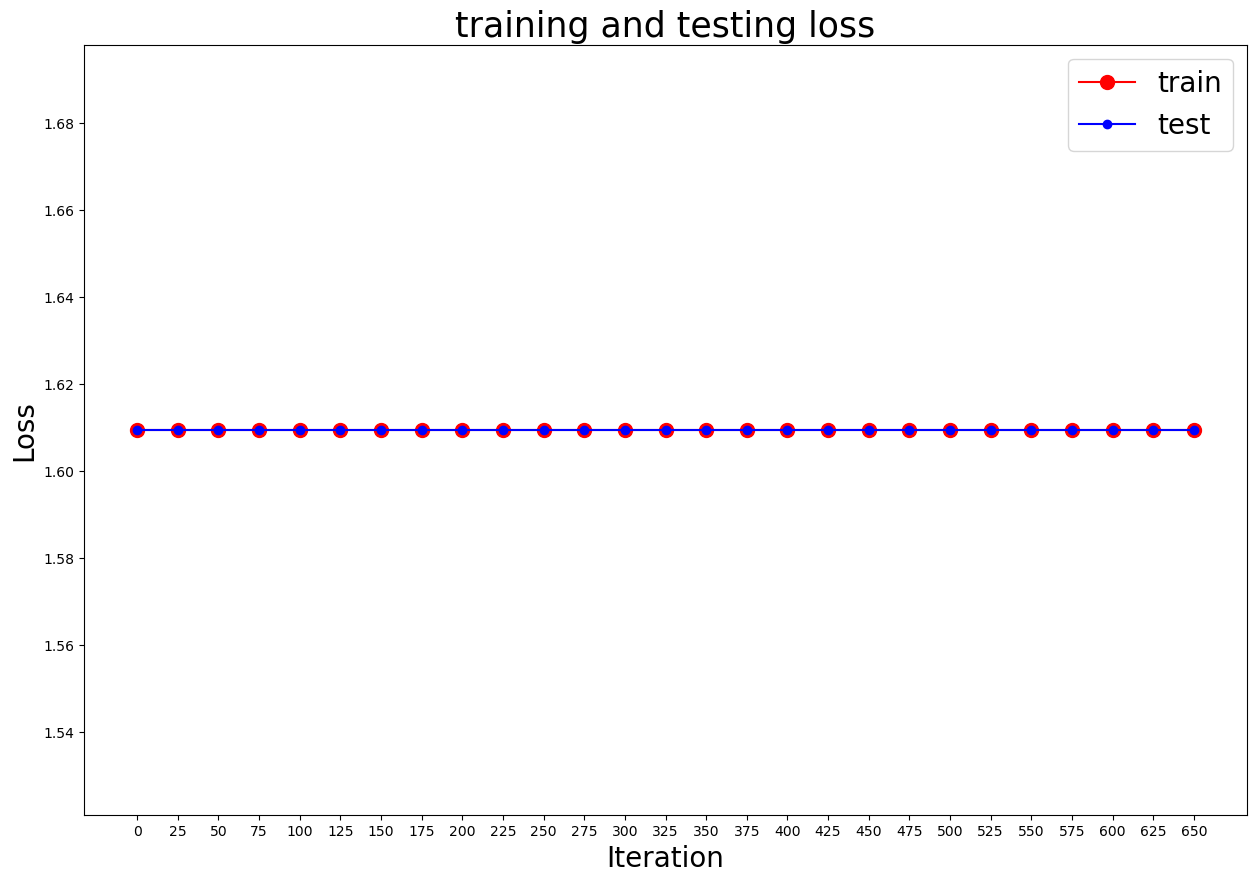

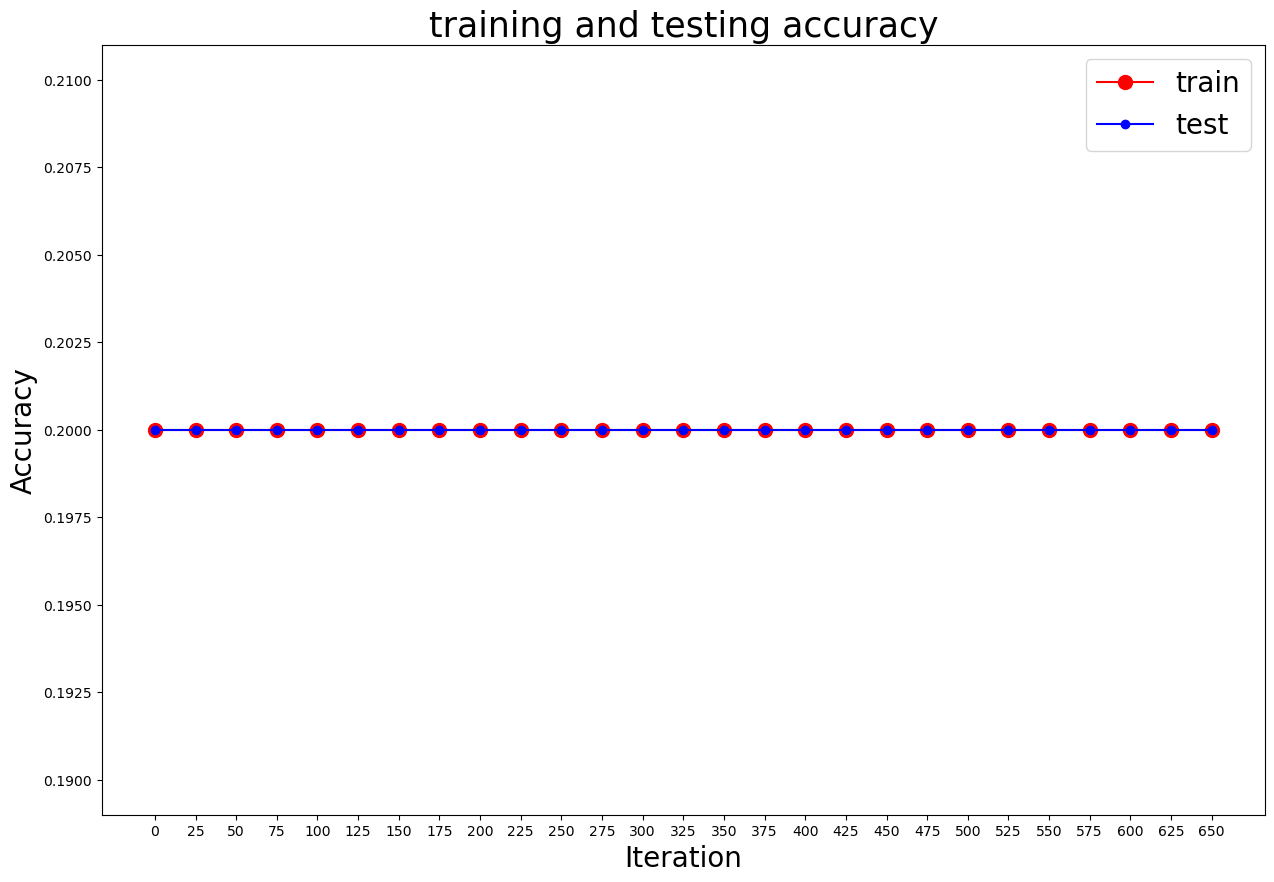

In [11]:
''' Weight Initialize '''
train_x, train_y = np.load('train_x.npy'), np.load('train_y.npy')
test_x, test_y = np.load('test_x.npy'), np.load('test_y.npy')

checkpoint = np.load('weights.npy', allow_pickle = True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

weights = init_weights
biases = init_biases

''' NORMALIZE '''
train_x = train_x / 255.0
test_x = test_x / 255.0

''' START TRAINING '''
FNN_initial_model = Model(weights, biases, lr = 0.01, initial = True, dropout_rate = 0.2)
print("FNN model architecture:")
print("--------------------------------------")
train(FNN_initial_model, epoch = 30, batch_size = 200, drop = False, shuffle = False)

## Some Discussion:
在(a)的時候train完30epoch後loss可以降到0.4左右而accuracy也能train到100%左右，但是test的accuracy大概到80%是極限，但如果能將epoch拉長應該能夠在上去一些;而(b)中將weight和bias初始化為0則會發現模型訓練不起來，甚至完全動不了，我推測是由於backpropagation的公式中微分傳回的運算會使用到weight矩陣，但由於weight都是0導致無法進行SGD的參數更新以至於模型無法進行訓練。

# 2.(a) Train the model by using the same settings in 1 and repeat 1(a).

FNN model architecture:
--------------------------------------
Final Train Loss:      26.712624274301405
Final Train Accuracy:  81.73999999999998 %

Final Test Loss:       40.47813222577198
Final Test Accuracy:   80.0 %


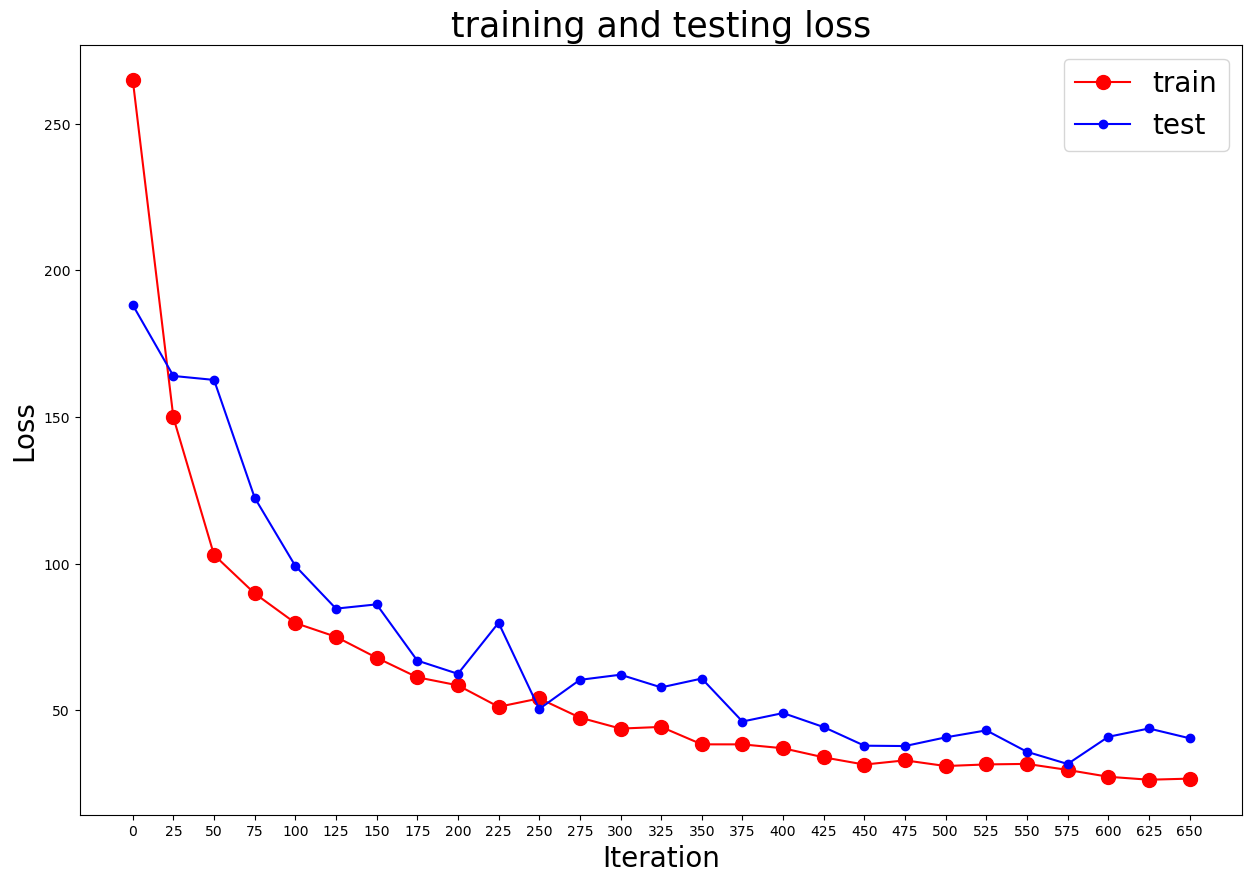

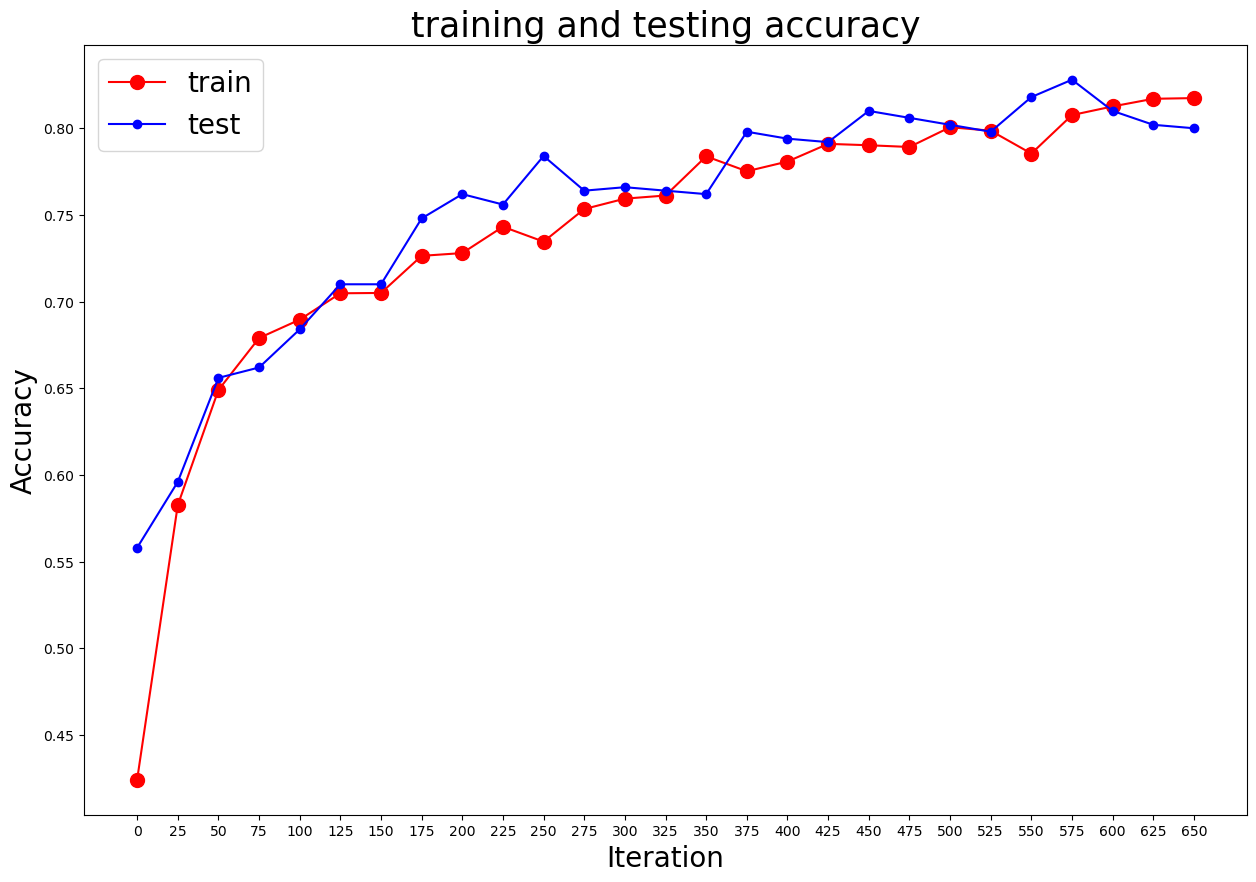

In [12]:
''' Dropout '''
train_x, train_y = np.load('train_x.npy'), np.load('train_y.npy')
test_x, test_y = np.load('test_x.npy'), np.load('test_y.npy')

checkpoint = np.load('weights.npy', allow_pickle = True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

weights = init_weights
biases = init_biases

''' NORMALIZE '''
train_x = train_x / 255.0
test_x = test_x / 255.0

''' START TRAINING '''
FNN_dropout_model = Model(weights, biases, lr = 0.01, initial = False, dropout_rate = 0.2)
print("FNN model architecture:")
print("--------------------------------------")
train(FNN_dropout_model, epoch = 30, batch_size = 200, drop = True, shuffle = False)

# 2.(b) Based on the experimental results, how the dropout layers affect the model performance and why?

## Some Discussion:
和沒有加上dropout前的相比可以發現dropout前training的loss可以下降到0.4左右且accuracy能達到100%左右，但是加上dropout後training的loss卻只能下降到26左右且accuracy只能達到80%左右，testing的部分則是結果差不多。經過dropout的網路，每一層都有神經元被消除，在消除上並沒有看見什麼規律性，因此我們可以看出Dropout的方法就是一邊隨機消除神經元，一邊訓練的方法。且從結果圖中可以發現加了dropout並不全為壞處，加之前可以觀察到有overfitting的狀況在，而加上dropout後可以明顯觀察到overfitting的狀況少了許多，test的accuracy也隨著loss的下降而上升，從結果印證了理論加上dropout能減少overfitting使模型訓練的更完善。

# 3.(a) Plot the learning curves of J(w) and the classification accuracy for every 25 iterations.Please show the final values of loss and accuracy.

FNN model architecture:
--------------------------------------
Final Train Loss:      0.5680833406743382
Final Train Accuracy:  97.5 %

Final Test Loss:       23.97043031865037
Final Test Accuracy:   77.8 %


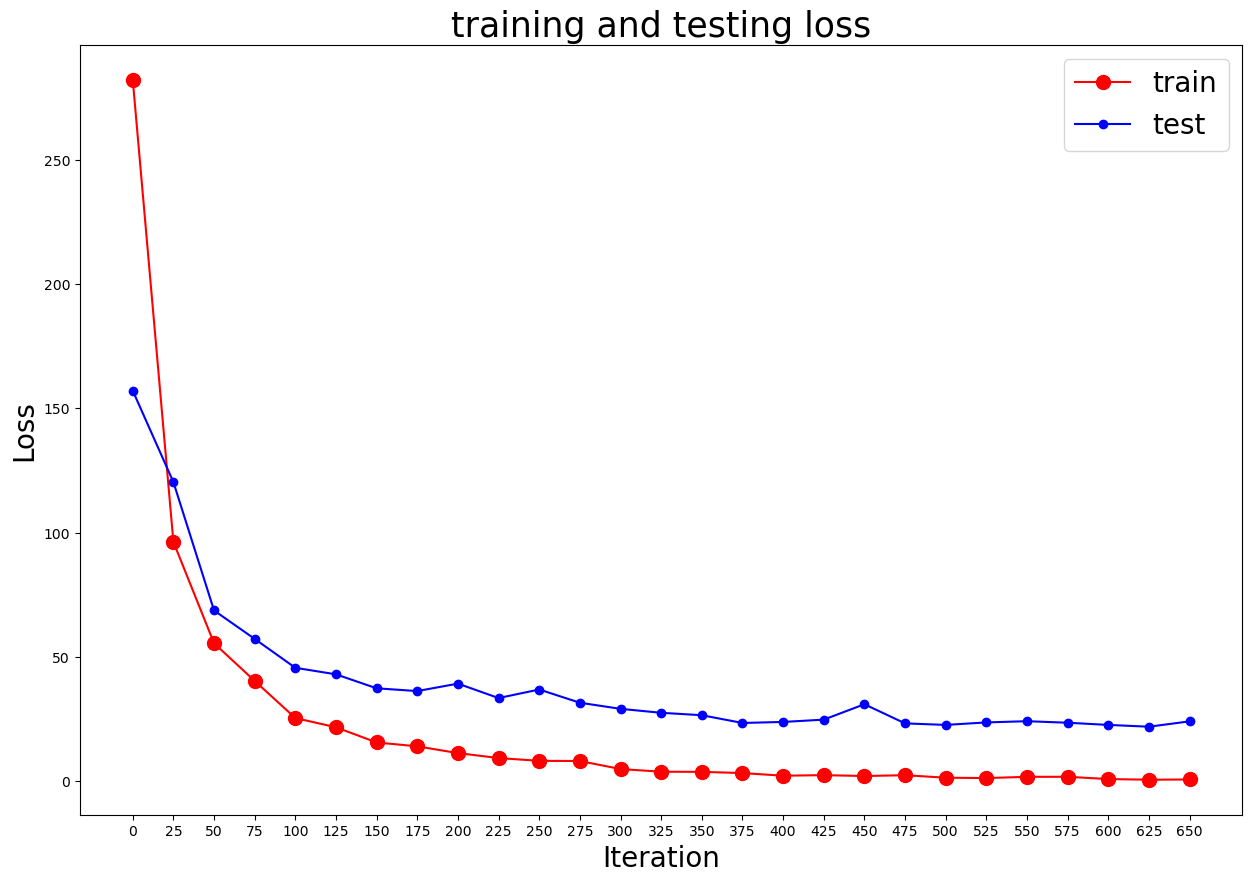

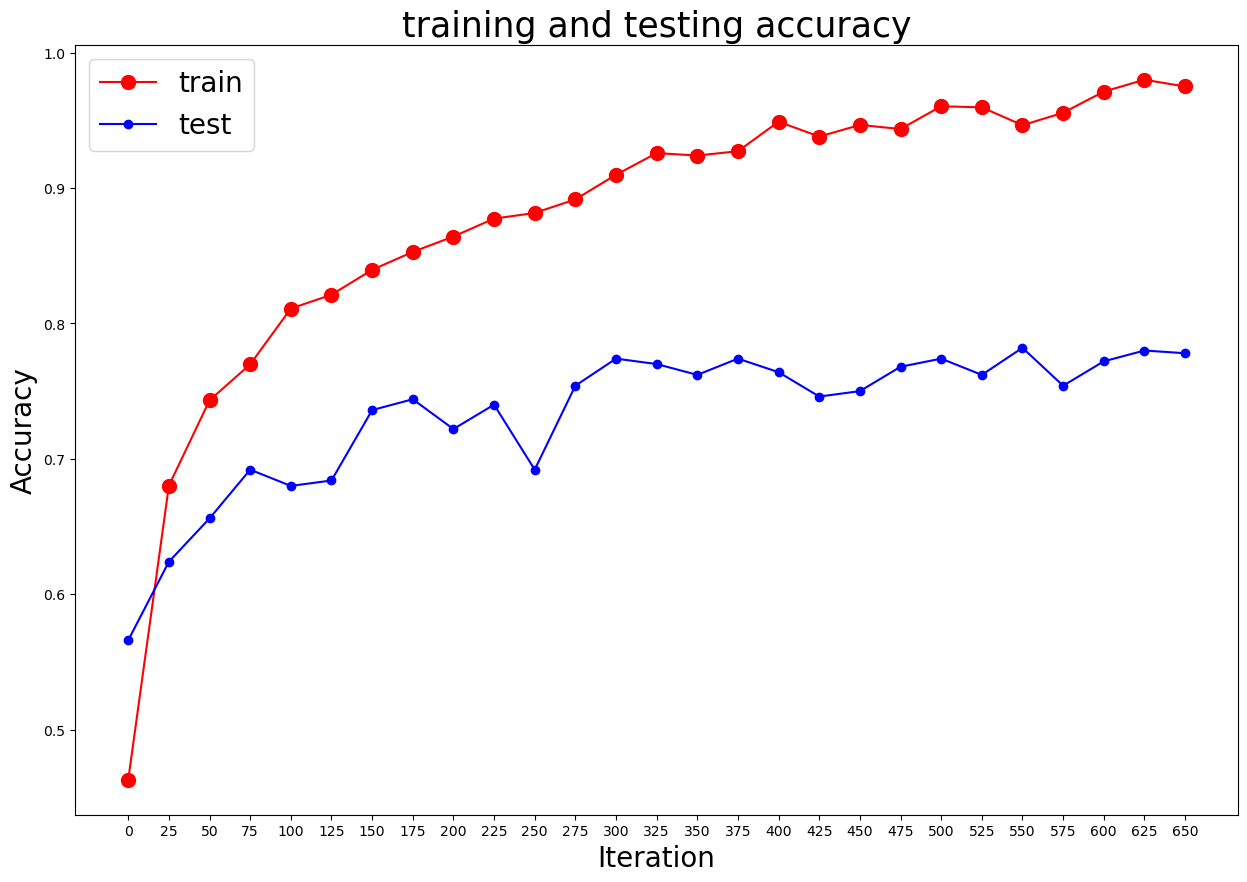

In [13]:
''' Mini-batch Shuffle '''
train_x, train_y = np.load('train_x.npy'), np.load('train_y.npy')
test_x, test_y = np.load('test_x.npy'), np.load('test_y.npy')

checkpoint = np.load('weights.npy', allow_pickle = True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

weights = init_weights
biases = init_biases

''' NORMALIZE '''
train_x = train_x / 255.0
test_x = test_x / 255.0

''' START TRAINING '''
FNN_shuffle_model = Model(weights, biases, lr = 0.01, initial = False, dropout_rate = 0.2)
print("FNN model architecture:")
print("--------------------------------------")
train(FNN_shuffle_model, epoch = 30, batch_size = 200, drop = False, shuffle = True)

# 3.(b) Based on the experimental results, how the process of reshuffling images affects the model performance and why?

# Some Discussion:
從結果上來看其實加不加shuffle並不太影響loss和accuracy，shuffle有時能使loss較為下降有時則會較為上升，但training的loss也是在0.5附近上下而accuracy也是幾乎到100%，test則是到80%。shuffle原本的目的是防止資料按造某種順序排好並打亂使trainig時較隨機，並防止模型在訓練過程抖動和使模型更加robust。shuffle前後的差別應該是shuffle後的結果曲線較為平緩，不像shuffle前有較大的震動。